In [3]:
import os
import re
import sys
import torch
import pandas as pd
from transformers import LlamaForCausalLM, LlamaTokenizer

/Users/ashutosh/miniconda3/envs/crp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

In [ ]:
# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

In [4]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything()

## Data Cleaning

In [26]:
model_id = 'meta-llama/Llama-2-7b-chat-hf'
df = pd.read_csv('../data/test_diabetes.csv', usecols=[0,1,2,3])

/var/folders/t2/jqcg5zcd0hn9gy7xfym2lqtm0000gn/T/ipykernel_94589/2924260342.py:2: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/test_diabetes.csv', usecols=[0,1,2,3])


In [27]:
df.head()

,PatientId,Text,Label,Text_label
0,10000117,A patient had 2 total visits to the hospital. ...,0.0,Low
1,10001217,A patient had 2 total visits to the hospital. ...,0.0,Low
2,10002428,A patient had 7 total visits to the hospital. ...,0.0,Low
3,10002769,A patient had 2 total visits to the hospital. ...,0.0,Low
4,10003299,A patient had 4 total visits to the hospital. ...,1.0,High


In [28]:
df.shape

(6909, 4)

In [44]:
df.Label = pd.to_numeric(df.Label, errors='coerce')
df.Label.value_counts()

Label
0.0    6448
1.0     458
Name: count, dtype: int64

In [34]:
df.Text_label.value_counts()

Text_label
Low          6448
High          458
 Insomnia       1
Name: count, dtype: int64

In [43]:
filtered_df = df[df['Text_label'].isin(['Low', 'High'])]
filtered_df.Text_label.value_counts()

Text_label
Low     6448
High     458
Name: count, dtype: int64

In [46]:
filtered_df.shape

(6906, 4)

In [47]:
filtered_df.to_csv('../data/test_diabetes_filtered.csv', index=False)

## Data Exploration

In [48]:
filtered_df.describe()

,Label
count,6906.000000
mean,0.066319
std,0.248857
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [50]:
filtered_df.dtypes

PatientId      object
Text           object
Label         float64
Text_label     object
dtype: object

In [51]:
filtered_df.Label = filtered_df.Label.astype('int8')

/var/folders/t2/jqcg5zcd0hn9gy7xfym2lqtm0000gn/T/ipykernel_94589/156979039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.Label = filtered_df.Label.astype('int8')


In [52]:
filtered_df.dtypes

PatientId     object
Text          object
Label           int8
Text_label    object
dtype: object

In [53]:
filtered_df.head()

,PatientId,Text,Label,Text_label
0,10000117,A patient had 2 total visits to the hospital. ...,0,Low
1,10001217,A patient had 2 total visits to the hospital. ...,0,Low
2,10002428,A patient had 7 total visits to the hospital. ...,0,Low
3,10002769,A patient had 2 total visits to the hospital. ...,0,Low
4,10003299,A patient had 4 total visits to the hospital. ...,1,High


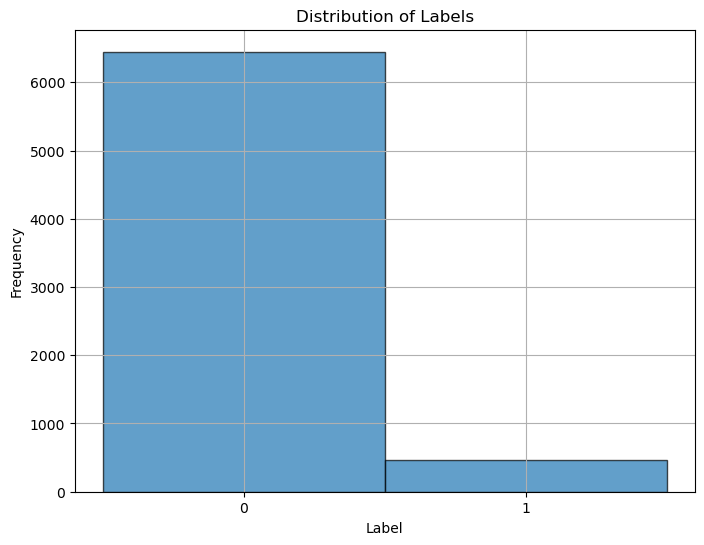

In [57]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))
filtered_df['Label'].hist(bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

In [62]:
filtered_df.Label.value_counts(normalize=True) * 100

Label
0    93.368086
1     6.631914
Name: proportion, dtype: float64